# Aortic Dissection Auto-segmentation for Computed Tomography (CT) 

This notebook is prepared for step-by-step description of auto-segmentation from the CT images of aortic dissection patients underwent TEVAR in Keck medical center.

In [1]:
# Import Packages

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import json
import cv2
import imageio
import os, glob
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator 


import seaborn as sns
import umetrics

In [2]:
# AD-DP=============================

#Step1:Defining the Input and Output

#Defining the general directory of the data
dataInputPath = 'volumes'
imagePathInput = os.path.join(dataInputPath, 'img/')
maskPathInput = os.path.join(dataInputPath, 'mask/')

dataOutputPath = 'slices/training/'
imageSliceOutput = os.path.join(dataOutputPath, 'img/img/')
maskSliceOutput = os.path.join(dataOutputPath, 'mask/img/')

#Step2:Normalizing the CT Images Using Hounsfield Transformation

#Normalize image
HOUNSFIELD_MIN = -1000
HOUNSFIELD_MAX = 2000
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

#Step3:Slicing and saving

# Slice image in all directions and save
SLICE_X = False
SLICE_Y = True
SLICE_Z = True

SLICE_DECIMATE_IDENTIFIER = 3

#Sample Image
imgPath = os.path.join(imagePathInput, 'P10_CTA_Chest_09_27.nii' )
maskPath = os.path.join(maskPathInput, 'P10_Segmentation_09_27.nii' )

In [3]:
# Load image and see max min Hounsfield units
#imgPath = os.path.join(imagePathInput, 'tooth1.nii')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)

(-3398.0, 11964.0, (247, 256, 800), numpy.memmap)

In [4]:
# Load image mask and see max min Hounsfield units
#maskPath = os.path.join(maskPathInput, 'tooth1.nii')
mask = nib.load(maskPath).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

(0.0, 1.0, (247, 256, 800), numpy.memmap)

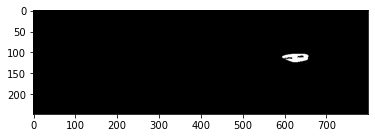

interactive(children=(IntSlider(value=0, description='n', max=255), Output()), _dom_classes=('widget-interact'…

interactive(children=(IntSlider(value=0, description='n', max=799), Output()), _dom_classes=('widget-interact'…

In [5]:
# Show image slice
imgSlice = mask[:,50,:]
plt.imshow(imgSlice, cmap='gray')
plt.show()

from ipywidgets import interact

@interact(n=(0, len(mask[0])-1))
def display_faces(n=0):
    #plt.figure()
    plt.imshow(mask[:, n, :], cmap='gray')
    plt.show()
    print(np.sum(mask[:, n, :]))

@interact(n=(0, len(mask[0][0])-1))
def display_faces(n=0):
    #plt.figure()
    plt.imshow(mask[:, :, n], cmap='gray')
    plt.show()
    print(np.sum(mask[:, :, n]))

In [6]:
# Helper Functions

# These functions are defined to automate the reading and slicing process of the images

# Normalize image
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

nImg = normalizeImageIntensityRange(img)
np.min(nImg), np.max(nImg), nImg.shape, type(nImg)

(0.0, 1.0, (247, 256, 800), numpy.ndarray)

In [7]:
# Read image or mask volume
def readImageVolume(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img
    
readImageVolume(imgPath, normalize=True)
readImageVolume(maskPath, normalize=False)

memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [8]:
# Save volume slice to file
def saveSlice(img, fname, path):
    img = np.uint8(img * 255)
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)
    print(f'[+] Slice saved: {fout}', end='\r')
    
#saveSlice(nImg[20,:,:], 'test', imageSliceOutput)
#saveSlice(mask[20,:,:], 'test', maskSliceOutput)

In [9]:
def sliceAndSaveVolumeImage(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    #difine a function to remove extra
    #def
    #...sum(figure)==0
    #return
    if SLICE_X:
        cnt += dimx
        #print('Slicing X: ')
        for i in range(dimx//5, 4*dimx//5):
            saveSlice(vol[i,:,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', path)
            
    if SLICE_Y:
        #cnt += dimy
        cnt += dimyEnd[index]+1-dimyStart[index]
        #print('Slicing Y: ')
        #for i in range(dimy//5, 4*dimy//5):
        for i in range(dimyStart[index],dimyEnd[index]+1):
            saveSlice(vol[:,i,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', path)
            
    if SLICE_Z:
        #cnt += dimz
        cnt += dimzEnd[index]+1-dimzStart[index]
        #print('Slicing Z: ')
        #for i in range(dimz//5, 4*dimz//5):
        for i in range(dimzStart[index],dimzEnd[index]+1):
            saveSlice(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)
    return cnt

In [10]:
def getStartAndEndOfTheSlice(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    #difine a function to remove extra
    MaskThreshold=500.0
    dimyStart=0
    dimyEnd=0
    dimzStart=0
    dimzEnd=0
    for i in range(dimy):
        if np.sum(vol[:,i,:])>MaskThreshold:
            dimyStart=i
            print('yStart=',dimyStart,'Sum=',np.sum(vol[:,i,:]))
            break
    for i in reversed(range(dimy)):
        if np.sum(vol[:,i,:])>MaskThreshold:
            dimyEnd=i
            print('yEnd=',dimyEnd,'Sum=',np.sum(vol[:,i,:]))
            break
            
    for i in range(dimz):
        if np.sum(vol[:,:,i])>MaskThreshold:
            dimzStart=i
            print('zStart=',dimzStart,'Sum=',np.sum(vol[:,:,i]))
            break
    for i in reversed(range(dimz)):
        if np.sum(vol[:,:,i])>MaskThreshold:
            dimzEnd=i
            print('zEnd=',dimzEnd,'Sum=',np.sum(vol[:,:,i]))
            break
    return dimyStart,dimyEnd,dimzStart,dimzEnd

for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'*.nii'))):
    numOfPatients=index+1
print('Number of patients=',numOfPatients)
dimyStart=np.zeros(numOfPatients, dtype=int)
dimyEnd  =np.zeros(numOfPatients, dtype=int)
dimzStart=np.zeros(numOfPatients, dtype=int)
dimzEnd  =np.zeros(numOfPatients, dtype=int)
    
for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'*.nii'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    dimyStart[index],dimyEnd[index],dimzStart[index],dimzEnd[index] = getStartAndEndOfTheSlice(img, 'patient'+str(index+1), maskSliceOutput)
    print(dimyStart[index],dimyEnd[index],dimzStart[index],dimzEnd[index])

Number of patients= 13
volumes\mask\P10_Segmentation_09_27.nii (247, 256, 800) 1303 0.0 1.0
247 256 800
yStart= 48 Sum= 538.0
yEnd= 185 Sum= 578.0
zStart= 298 Sum= 6110.0
zEnd= 734 Sum= 504.0
48 185 298 734
volumes\mask\P11_Segmentation_09_28.nii (105, 186, 732) 1023 0.0 1.0
105 186 732
yStart= 68 Sum= 561.0
yEnd= 180 Sum= 514.0
zStart= 484 Sum= 518.0
zEnd= 656 Sum= 586.0
68 180 484 656
volumes\mask\P12_Segmentation_09_28.nii (179, 79, 374) 632 0.0 1.0
179 79 374
yStart= 9 Sum= 769.0
yEnd= 71 Sum= 558.0
zStart= 251 Sum= 506.0
zEnd= 333 Sum= 578.0
9 71 251 333
volumes\mask\P13_Segmentation_09_30.nii (312, 206, 778) 1296 0.0 1.0
312 206 778
yStart= 38 Sum= 578.0
yEnd= 147 Sum= 601.0
zStart= 208 Sum= 524.0
zEnd= 666 Sum= 521.0
38 147 208 666
volumes\mask\P14_Segmentation_09_30.nii (287, 201, 749) 1237 0.0 1.0
287 201 749
yStart= 28 Sum= 826.0
yEnd= 171 Sum= 636.0
zStart= 152 Sum= 538.0
zEnd= 647 Sum= 849.0
28 171 152 647
volumes\mask\P15_Segmentation_10_03.nii (249, 235, 217) 701 0.0 1.0


In [11]:
# Read and process image volumes
for index, filename in enumerate(sorted(glob.iglob(imagePathInput+'*.nii'))):
    if index==9:
        SLICE_X = False
        SLICE_Y = True
        SLICE_Z = False
        print('Save Y')
    else:
        SLICE_X = False
        SLICE_Y = False
        SLICE_Z = True
        print('Save Z')
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'patient'+str(index+1), imageSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

Save Z
volumes\img\P10_CTA_Chest_09_27.nii (247, 256, 800) 1303 0.0 1.0
247 256 800
[+] Slice saved: slices/training/img/img/patient1-slice734_z.png
volumes\img\P10_CTA_Chest_09_27.nii, 437 slices created 

Save Z
volumes\img\P11_CTA_Chest_09_28.nii (105, 186, 732) 1023 0.0 1.0
105 186 732
[+] Slice saved: slices/training/img/img/patient2-slice656_z.png
volumes\img\P11_CTA_Chest_09_28.nii, 173 slices created 

Save Z
volumes\img\P12_CTA_Chest_09_28.nii (179, 79, 374) 632 0.0 1.0
179 79 374
[+] Slice saved: slices/training/img/img/patient3-slice333_z.png
volumes\img\P12_CTA_Chest_09_28.nii, 83 slices created 

Save Z
volumes\img\P13_CTA_Chest_09_30.nii (312, 206, 778) 1296 0.0 1.0
312 206 778
[+] Slice saved: slices/training/img/img/patient4-slice666_z.png
volumes\img\P13_CTA_Chest_09_30.nii, 459 slices created 

Save Z
volumes\img\P14_CTA_Chest_09_30.nii (287, 201, 749) 1237 0.0 1.0
287 201 749
[+] Slice saved: slices/training/img/img/patient5-slice647_z.png
volumes\img\P14_CTA_Chest_0

In [12]:
# Read and process image mask volumes
for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'*.nii'))):
    if index==9:
        SLICE_X = False
        SLICE_Y = True
        SLICE_Z = False
        print('Save Y')
    else:
        SLICE_X = False
        SLICE_Y = False
        SLICE_Z = True
        print('Save Z')
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'patient'+str(index+1), maskSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

Save Z
volumes\mask\P10_Segmentation_09_27.nii (247, 256, 800) 1303 0.0 1.0
247 256 800
[+] Slice saved: slices/training/mask/img/patient1-slice734_z.png
volumes\mask\P10_Segmentation_09_27.nii, 437 slices created 

Save Z
volumes\mask\P11_Segmentation_09_28.nii (105, 186, 732) 1023 0.0 1.0
105 186 732
[+] Slice saved: slices/training/mask/img/patient2-slice656_z.png
volumes\mask\P11_Segmentation_09_28.nii, 173 slices created 

Save Z
volumes\mask\P12_Segmentation_09_28.nii (179, 79, 374) 632 0.0 1.0
179 79 374
[+] Slice saved: slices/training/mask/img/patient3-slice333_z.png
volumes\mask\P12_Segmentation_09_28.nii, 83 slices created 

Save Z
volumes\mask\P13_Segmentation_09_30.nii (312, 206, 778) 1296 0.0 1.0
312 206 778
[+] Slice saved: slices/training/mask/img/patient4-slice666_z.png
volumes\mask\P13_Segmentation_09_30.nii, 459 slices created 

Save Z
volumes\mask\P14_Segmentation_09_30.nii (287, 201, 749) 1237 0.0 1.0
287 201 749
[+] Slice saved: slices/training/mask/img/patient5-s

In [13]:
from ipywidgets import interact

@interact(n=(dimyStart[0],dimyEnd[0]))
def display_faces(n=0):
    #plt.figure()
    #plt.imshow(mask[:, n, :], cmap='gray')
    fig, ax  = plt.subplots(1,2)
    ax[0].imshow(nImg[:, n, :], cmap='gray')
    ax[1].imshow(mask[:, n, :], cmap='gray')
    plt.show()
    print(np.sum(mask[:, n, :]))

@interact(n=(dimzStart[0],dimzEnd[0]))
def display_faces(n=0):
    #plt.figure()
    #plt.imshow(mask[:, :, n], cmap='gray')
    fig, ax  = plt.subplots(1,2)
    ax[0].imshow(nImg[:, :, n], cmap='gray')
    ax[1].imshow(mask[:, :, n], cmap='gray')
    plt.show()
    print(np.sum(mask[:, :, n]))

interactive(children=(IntSlider(value=48, description='n', max=185, min=48), Output()), _dom_classes=('widget-…

interactive(children=(IntSlider(value=298, description='n', max=734, min=298), Output()), _dom_classes=('widge…

In [14]:
#End of the Code